In [42]:
import pandas as pd
import numpy as np
import pickle
import config
import spotipy
import json
from IPython.display import IFrame
import Levenshtein
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score 
from spotipy.oauth2 import SpotifyClientCredentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

df=pd.read_csv(r"C:\Users\Erensu Akdogan\Downloads\songs.xls")
top100_chart=pd.read_csv(r"C:\Users\Erensu Akdogan\Downloads\top100.xls")

In [43]:
#CLUSTERING 
    nof = str(input('Please put the number of clusters: '))
    tdf = df.drop(columns = ['time_signature', 'duration_ms', 'analysis_url', 'track_href', 'uri', 'id', 'type'])
    X = tdf
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
    kmeans = KMeans(n_clusters=int(nof), random_state=1234)
    kmeans.fit(X_scaled_df)
    clusters = kmeans.predict(X_scaled_df)
    X["cluster"] = clusters # add  clusters
    X['id'] = df['id'] # add back ids


Please put the number of clusters:  10


C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

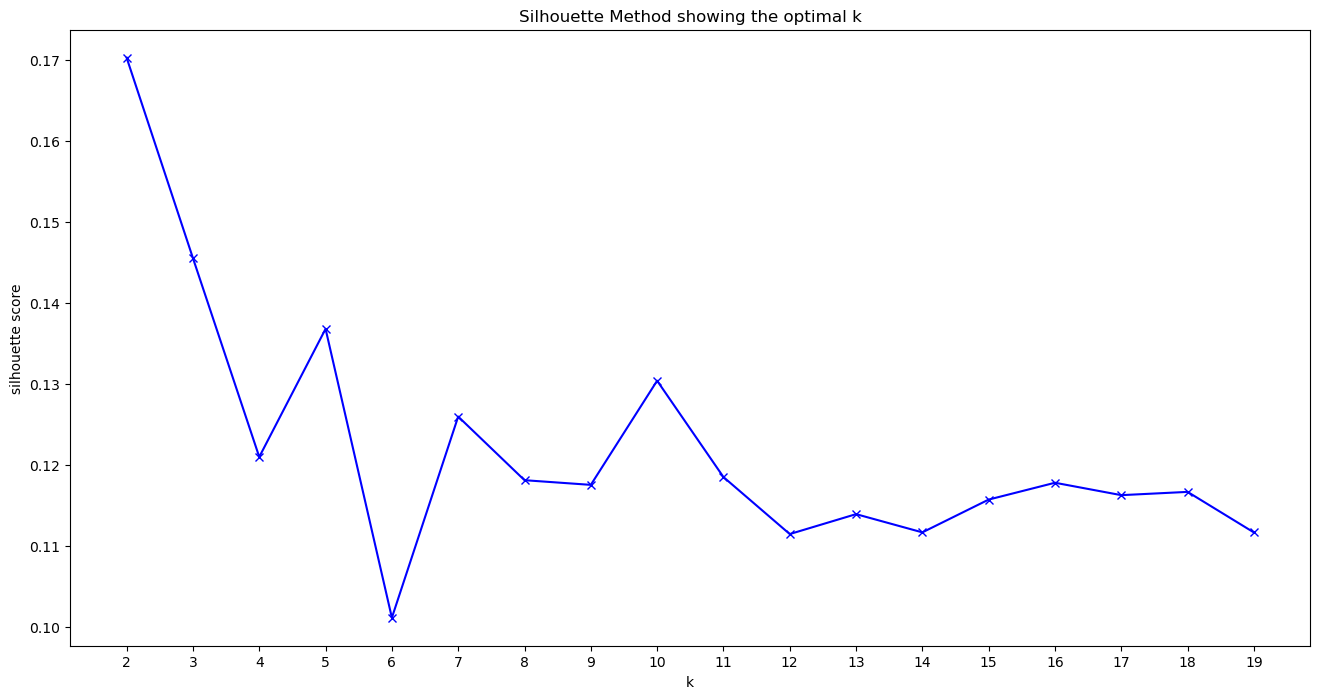

In [23]:
# Finding the optimal number of clusters
K = range(2, 20)
silhouette = []
for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234, n_init='auto')
    kmeans.fit(X_scaled_df)
    
    filename = "kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [44]:

#SEARCH FOR THE INPUT SONG
def spotify_search(input_song):
    results = sp.search(q=input_song,limit=1,market="GB")
    track_id = results["tracks"]["items"][0]["id"]
    return track_id

#PULL ATRIBUTES FOR THE INPUT SONG & SCALE
def pull_atributes (track_id):
    song_features = pd.DataFrame(sp.audio_features(track_id)) #pulls the audio features
    song_features = song_features.drop(columns = ['time_signature', 'duration_ms', 'analysis_url', 'track_href', 'uri', 'id', 'type'])
    sf_scaled = pd.DataFrame(scaler.transform(song_features) , columns=song_features.columns)
    recommend_and_play(sf_scaled)
    return sf_scaled

#PLAY SONG
def play_song(rec_track_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+rec_track_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )
# RECOMMEND AND PLAY
def recommend_and_play(sf_scaled):
#predict the kluster of the song
    song_k = kmeans.predict(sf_scaled)[0]
    #and finally recommend 
    rec_song =X[X['cluster'] == song_k].sample(1)
    #play the song
    for song in rec_song['id']:
        display(play_song(song))

# LEV DISTANCE
def dist_count(input_song, threshold=2):
    similar_words = []
    for value in top100_chart['song'].values:
        distance = Levenshtein.distance(input_song, value)
        if distance <= threshold:
            similar_words.append(value)
    return similar_words



Please put the number of clusters:  10


C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [48]:
# HOT OR WHAT
def hot_or_what():
    input_song = input('Please enter the name of the song you like: ')
    one_song = False
    while not one_song:
        similar_words = dist_count(input_song)
        if len(similar_words) == 0:
            print('Oh no! Your song is not that hot:(! No worries, I will recommend two songs similar to yours:')
            track_id=spotify_search(input_song)
            sf_scaled=pull_atributes(track_id)
            recommend_and_play(sf_scaled)
            one_song = True
        elif len(similar_words) == 1:
            print('I hope the song you mean is:', similar_words[0])
            print('Your song is hot! Here is another hot song for you:')
            print(top100_chart.sample(1))
            one_song = True
        else:
            print('Which one do you mean?')
            print(similar_words)
            hot_or_not()

In [50]:
hot_or_what()

Please enter the name of the song you like:  whats my age again


Oh no! Your song is not that hot:(! No worries, I will recommend two songs similar to yours:


In [192]:
df.id.value

id
7E81YAfHOaSlnevLjKMghT    1
43btz2xjMKpcmjkuRsvxyg    1
5qBmTXgCdtvCqKc9yrLoWg    1
27QvYgBk0CHOVHthWnkuWt    1
1vJQzxoByUo0CoiEgAdgDk    1
                         ..
2CVBUIOpqAkOGDlRORvSYK    1
2J3hiL5egugOFdHFqDuSP7    1
6W7ztLBiRzBN46ZaPAcQ0F    1
3bceL3NJmM8sKwr5dyrKAz    1
4D01oA1mGouaAT7fubvKRT    1
Name: count, Length: 1868, dtype: int64

In [136]:
tdf = df.drop(columns = ['time_signature', 'duration_ms', 'analysis_url', 'track_href', 'uri', 'id', 'type'])

In [137]:
tdf.info

<bound method DataFrame.info of       danceability  energy  key  loudness  mode  speechiness  acousticness  \
0            0.628   0.953   10    -4.989     0       0.0626      0.002760   
1            0.820   0.731    9    -6.020     1       0.1590      0.013300   
2            0.677   0.665    7    -5.171     1       0.0305      0.560000   
3            0.677   0.778    9    -7.578     1       0.2060      0.679000   
4            0.320   0.620    0    -9.686     1       0.0594      0.640000   
...            ...     ...  ...       ...   ...          ...           ...   
1863         0.756   0.730   11    -5.292     1       0.0320      0.022400   
1864         0.531   0.948    9    -5.438     1       0.0568      0.006000   
1865         0.558   0.768    2    -9.997     1       0.0343      0.121000   
1866         0.445   0.706    8    -9.803     1       0.0461      0.234000   
1867         0.490   0.827    8    -9.481     1       0.0482      0.000212   

      instrumentalness  livenes

In [139]:
X = tdf
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
#display(X.head())
print()
display(X_scaled_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.148152,1.384140,1.324943,0.792554,-1.548019,-0.045818,-0.838324,-0.172491,1.486485,-0.327222,-0.371298
1,1.394354,0.273242,1.046196,0.508128,0.645987,1.399020,-0.795251,-0.266820,-0.347552,0.820616,0.221654
2,0.466193,-0.057025,0.488702,0.742345,0.645987,-0.526931,1.438909,-0.266951,0.935034,0.461401,-1.715985
3,0.466193,0.508432,1.046196,0.078316,0.645987,2.103453,1.925218,0.173889,-0.791810,0.985773,-1.716841
4,-1.850964,-0.282207,-1.462526,-0.503227,0.645987,-0.093780,1.765839,-0.266503,0.408369,-0.504765,-1.293978


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

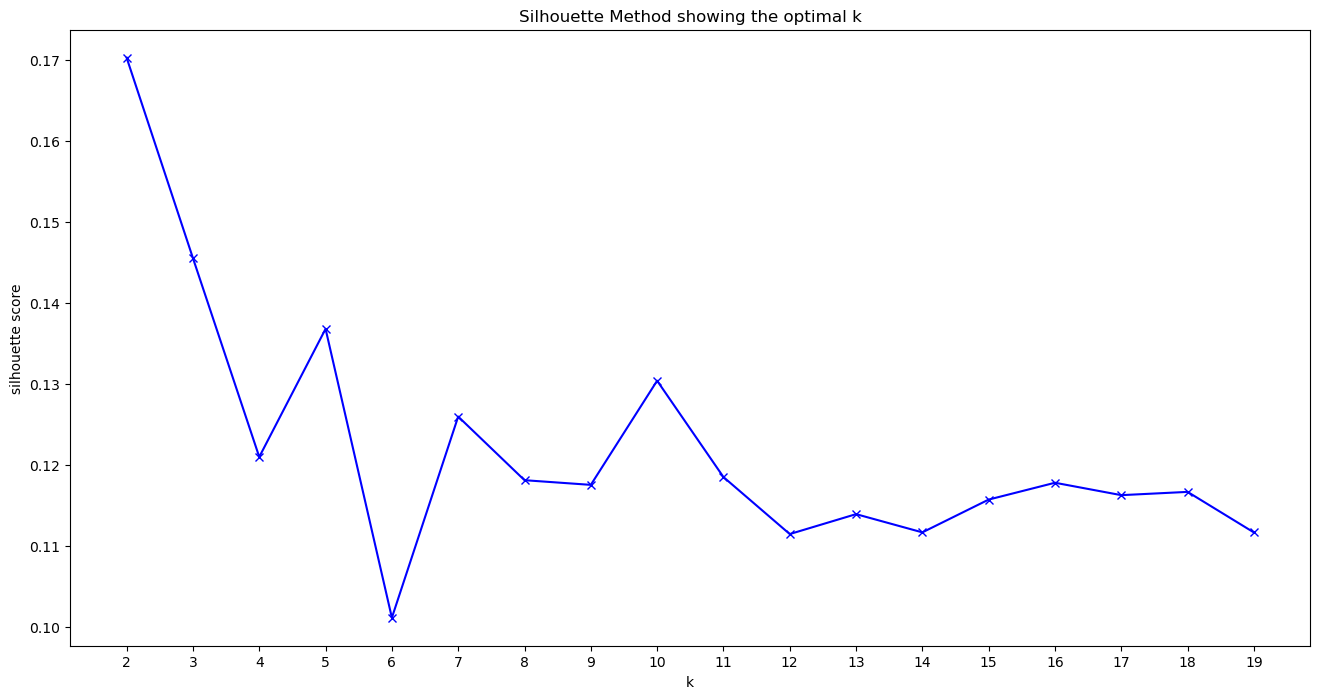

In [140]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234, n_init='auto')
    kmeans.fit(X_scaled_df)
    
    filename = "kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [142]:
kmeans = KMeans(n_clusters=10, random_state=1234)
kmeans.fit(X_scaled_df)

C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10, random_state=1234)

In [143]:
labels = kmeans.labels_
np.unique(labels)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [144]:
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index()

0     80
1    173
2    195
3    358
4    253
5    226
6    184
7    231
8     98
9     70
Name: count, dtype: int64

In [145]:
X["cluster"] = clusters
X['id'] = df['id']

In [146]:

from spotipy.oauth2 import SpotifyClientCredentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

In [150]:
# Search and pull the track_id

def spotify_search(input_song):
    results = sp.search(q=input_song,limit=1,market="GB")
    track_id = results["tracks"]["items"][0]["id"]
    return track_id




In [151]:
# Pull the attributes of the id and clean & scale

def pull_atributes (track_id):
    track_id = spotify_search(input_song) # Call the search function
    song_features = pd.DataFrame(sp.audio_features(track_id)) #pulls the audio features
    song_features = song_features.drop(columns = ['time_signature', 'duration_ms', 'analysis_url', 'track_href', 'uri', 'id', 'type'])
    sf_scaled = pd.DataFrame(scaler.transform(song_features) , columns=song_features.columns)
    return sf_scaled


In [149]:
X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster,id
0,0.628,0.953,10,-4.989,0,0.0626,0.002760,0.013200,0.4270,0.515,111.134,5,7E81YAfHOaSlnevLjKMghT
1,0.820,0.731,9,-6.020,1,0.1590,0.013300,0.000019,0.1310,0.793,127.076,3,5RzFJd6W40SDTyZkX6xx45
2,0.677,0.665,7,-5.171,1,0.0305,0.560000,0.000001,0.3380,0.706,74.981,4,70XtWbcVZcpaOddJftMcVi
3,0.677,0.778,9,-7.578,1,0.2060,0.679000,0.061600,0.0593,0.833,74.958,0,0CVlP2QMGqr9kP527ay07S
4,0.320,0.620,0,-9.686,1,0.0594,0.640000,0.000064,0.2530,0.472,86.327,2,6lFZbCc7pn6Lme1NP7qQqQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863,0.756,0.730,11,-5.292,1,0.0320,0.022400,0.000012,0.1390,0.917,115.977,3,4vqHz44pzFSfDNIE20QRBu
1864,0.531,0.948,9,-5.438,1,0.0568,0.006000,0.011700,0.6940,0.498,136.891,8,3UrDYCWfY6fTsiA63NNL27
1865,0.558,0.768,2,-9.997,1,0.0343,0.121000,0.062600,0.1240,0.429,81.909,4,44aTAUBF0g6sMkMNE8I5kd
1866,0.445,0.706,8,-9.803,1,0.0461,0.234000,0.000252,0.2050,0.768,80.823,4,43DeSV93pJPT4lCZaWZ6b1


In [211]:
def play_song(track_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+track_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

In [209]:
def recommend_and_play():
#predict the kluster
    sf_scaled = pull_atributes (track_id)
    song_k = kmeans.predict(sf_scaled)[0]
    song_k
    #and finally recommend 
    rec_song =X[X['cluster'] == song_k].sample(1)
    #play the song
    for song in rec_song['id']:
        display(play_song(song))


In [212]:
recommend_and_play()